In [21]:
import pandas as pd
import yfinance as yf
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import gurobipy as gp
from gurobipy import GRB

In [22]:
# function to fetch data from yahoo finance for 1 year
def FetchData(Tickers,Period="1y",Interval='1d',Start=None,End=None,Group_by='column',Column='Adj Close'):

    """
    Return the data for tickers
    Parameters:
        tickers : str, list             List of tickers to download
        period : str             Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max Either Use period parameter or use start and end
        interval : str             Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo Intraday data cannot extend last 60 days
        start: str             Download start date string (YYYY-MM-DD) or _datetime. Default is 1900-01-01
        end: str             Download end date string (YYYY-MM-DD) or _datetime. Default is now
        group_by : str             Group by 'ticker' or 'column' (default)
    """
    StockData = yf.download(Tickers,start=Start,end=End,period=Period,interval=Interval)

    if Column!=None:
        SelectedData = StockData[Column]
    else:
        SelectedData = StockData

    return(SelectedData)



In [70]:
def Calculation(Data_Selected):
    ''' calculate the mean percent change and covariance for the stocks. Then annualized the value and return. '''
   
    Stock_pct_change = Data_Selected.pct_change()
    Mean_Change = Stock_pct_change.mean()*252
    Change_Cov = Stock_pct_change.cov()*252
    
    return(Mean_Change,Change_Cov)

In [71]:
a,b = Calculation(StockPrice)

In [24]:
def ComparitiveDisplay(StockData):
    # Display the growth of stocks by setting starting price to 100
    # The graph is displayed then
    ticker_list=StockData.columns
    temp_df = pd.DataFrame()
    for i in ticker_list:
        temp_df[i]=(StockData[i]/StockData[i][0])*100
    
        
    plt.figure(figsize=(20,5))
    sns.lineplot(data=temp_df)

    return()
    

In [25]:
# Selection of the Stocks for optimization
Tickers_List = ['GE','T','PG','AMZN','CL','CVS']
StockPrice = FetchData(Tickers_List)
Stock_Mean_Change, Stock_Cov_Change = Calculation(StockPrice)

[*********************100%***********************]  6 of 6 completed


()

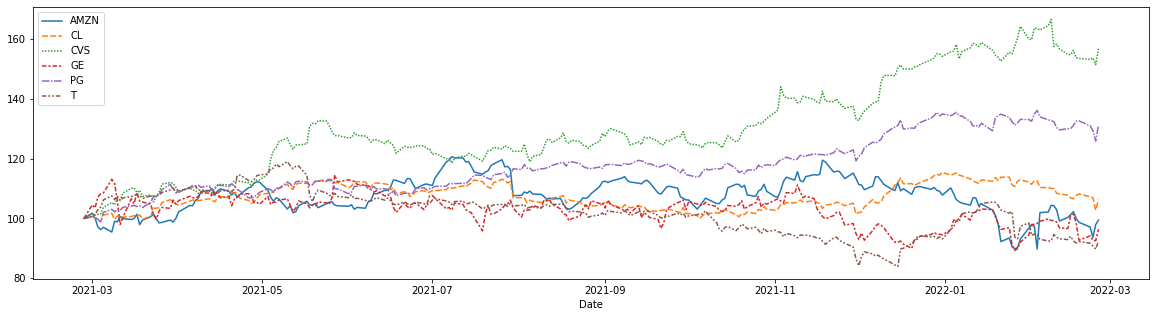

In [26]:
ComparitiveDisplay(StockPrice)

In [40]:
def Performance(weights, mean_change, change_cov):
    
    portfolio_return = np.dot(weights, mean_change)
    porfolio_std = np.dot(np.dot(change_cov, weights),weights)
    return(portfolio_return,porfolio_std)

In [28]:
Portfolio_Weights = np.ones(6)/6
Performance(Portfolio_Weights, Stock_Mean_Change, Stock_Cov_Change)

(0.13795580318357042, 0.016006982053472063)

In [29]:
def Efficient_Frontier_Montcarlo(Tickers,no_of_iter):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    temp_data = pd.DataFrame(columns=['Return','Std_dev'])
    for i in range(no_of_iter):
        weights=np.random.random(6)
        portfolio_weights = weights/weights.sum()
        port_ret, port_std = Performance(portfolio_weights,stock_mean_change,stock_cov_change)
        temp1=pd.DataFrame([[port_ret,port_std]],columns=['Return','Std_dev'])
        temp_data = pd.concat([temp_data,temp1],ignore_index=True)
    plt.figure(figsize=(20,5))
    sns.scatterplot(data=temp_data,y='Return',x='Std_dev')
    return()

[*********************100%***********************]  6 of 6 completed


()

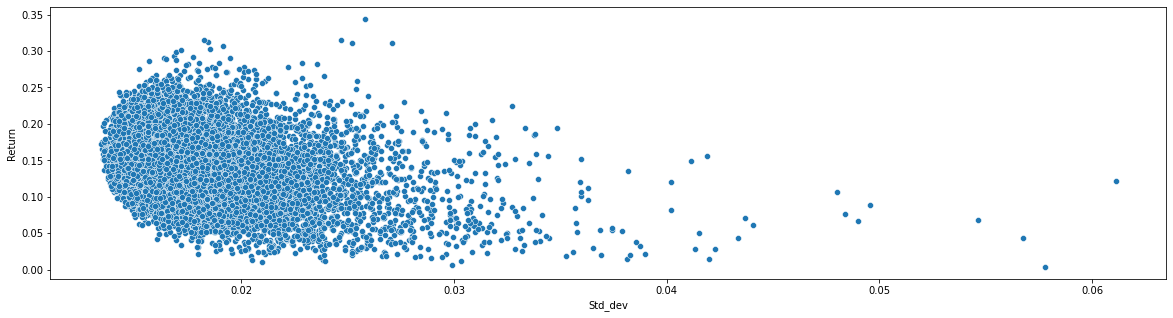

In [30]:
Efficient_Frontier_Montcarlo(Tickers_List,10000)

In [31]:
def SharpeRatio(Tickers,weights,RiskFreeRate):
    stockdata = FetchData(Tickers)
    stock_mean_change, stock_cov_change = Calculation(stockdata)
    port_ret, port_std = Performance(weights,stock_mean_change,stock_cov_change)

    return((port_ret-RiskFreeRate)/port_std)
    


In [32]:
SharpeRatio(Tickers_List, Portfolio_Weights, 0.025)

[*********************100%***********************]  6 of 6 completed


7.056659229456065

In [84]:
def OptimizedPortfolio(Tickers, RiskFreeRate):

    stock_data = FetchData(Tickers)
    stock_mean_ret, stock_covariance = Calculation(stock_data)

    

    m = gp.Model('PortFolio optimization')

    weight = m.addMVar(len(Tickers))

    m.addConstr(weight.sum() == 1)

    port_std = weight @ stock_covariance.values @ weight
    port_ret = weight @ stock_mean_ret.values
    sharperatio = port_std
    m.setObjective(sharperatio, GRB.MINIMIZE)

    m.update()
    m.optimize()


    
    return(weight)


In [85]:
OptimizedPortfolio(Tickers_List, 0.025)

[*********************100%***********************]  6 of 6 completed
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 6 columns and 6 nonzeros
Model fingerprint: 0xa46d5dfb
Model has 21 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [4e-05, 2e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.00s
Presolved: 1 rows, 6 columns, 6 nonzeros
Presolved model has 21 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 5
 AA' NZ     : 1.500e+01
 Factor NZ  : 2.100e+01
 Factor Ops : 9.100e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   1.73103441e+05 -1.73103441e+05  4.00e+03 1.17e-05  1.00e

<(6,) matrix variable *awaiting update*>

array([[ 9.01492173e-02, -1.44453941e-03,  9.36535878e-06,
         1.47161731e-02, -4.43032124e-03, -2.84522417e-03],
       [-1.44453941e-03,  2.44775667e-02,  1.18606603e-02,
         3.96806822e-03,  1.73749064e-02,  1.00743541e-02],
       [ 9.36535878e-06,  1.18606603e-02,  4.47598054e-02,
         1.65831861e-02,  1.07139968e-02,  8.55629084e-03],
       [ 1.47161731e-02,  3.96806822e-03,  1.65831861e-02,
         1.04647237e-01,  1.99372407e-03,  2.32829240e-02],
       [-4.43032124e-03,  1.73749064e-02,  1.07139968e-02,
         1.99372407e-03,  2.28978285e-02,  9.66593063e-03],
       [-2.84522417e-03,  1.00743541e-02,  8.55629084e-03,
         2.32829240e-02,  9.66593063e-03,  4.91607090e-02]])